In [1]:
# standard modules
import datetime
import time

# 3rd party modules
import pandas as pd
import numpy as np
import seaborn as sb

# local modules
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.datasets import CDSDataset, JHUDataset
from libs.datasets import DHBeds, FIPSPopulation
from libs.datasets.dataset_utils import AggregationLevel

# set vendor defaults
# Pandas: display format for float uses two decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# autoreload reloads modules automatically before entering
# the execution of code typed at the IPython prompt.
# https://ipython.org/ipython-doc/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [3]:
# import matplotlib and related libraries
%matplotlib inline
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
# import core datasets
# TODO describe contents of datasets
timeseries_data = JHUDataset.local().timeseries()
beds_data = DHBeds.local().beds()
population_data = FIPSPopulation.local().population()

Did not match 5 codes to county data.
['60000', '66000', '69000', '78000', '88888']
Could not match ('MP', 'Saipan')
Could not match ('VI', 'Saint Croix')
Could not match ('VI', 'Saint Thomas')
Could not match ('GU', 'Guam')
Could not match ('AS', 'American Samoa')


In [5]:
def model_state(country, state, interventions=None):
    """Parameterize and run the SEIR model in the given country
    and state using the provided intervention scheme.

    Parameters
    ----------
    country : str
        Currently only "USA".
    state : str
        Two-character state postal code, e.g., "TX"
    interventions : list
        List of interventions, defined by dictionaries, to apply.
        If None, no interventions are applied.
        TODO describe dictionary structure required

    Returns
    -------
    list
        Element 1: a dataframe containing the model results.
        Element 2: TODO describe element 2 ("soln")

    """
    DATA_PARAMETERS = {
        'timeseries': timeseries_data.get_subset(AggregationLevel.STATE).get_data(country=country, state=state),
        'beds': beds_data.get_state_level(state),
        'population': population_data.get_state_level(country, state)
    }
    
    ####################################################
    # Define constants used in MODEL_PARAMETERS entry
    # calculations
    ####################################################
    #
    # the factor by which the number of cases increased per day
    # based on real-world observations of the COVID-19 outbreak
    # in the USA
    observed_daily_growth_rate = 1.21
    #
    # fraction of infected, symptomatic cases which are
    # hospitalized (i.e., move from class I_1 to
    # class I_2)
    hospitalization_rate = 0.0727
    #
    # fraction of infected, symptomatic cases which need
    # ICU care (i.e., move from class I_2 to class I_3)
    hospitalized_cases_requiring_icu_care = 0.1397

    # Pack all of the assumptions and parameters into a dict that
    #can be passed into the model  
    MODEL_PARAMETERS = { 
        # model type, currently "seir" or "asymp"
        'model': 'asymp',
        
        # columns to be displayed in output line plots and tables
        # NOTE: only columns produced by the model module
        # (e.g., ./libs/epi_models/TalusSEIR.py) in its function
        # `dataframe_ify` should be included
        'model_cols': [
          'total',
          'susceptible',
          'exposed',
          'infected',
          'asymp',
          'infected_a',
          'infected_b',
          'infected_c',
          'recovered',
          'dead',
        ],
        
        # if True, use the A. Hill model parameters directly,
        # otherwise calculate them using the `generate_epi_params`
        # function of the epi model module
        'use_harvard_params': False,
        
        # if True, use the A. Hill model parameters that yield an
        # R0 of 2.4, otherwise calculate them using the 
        # `generate_epi_params` function of the epi model module
        'fix_r0': False,
        
        # the number of days to simulate
        'days_to_model': 270,

        # # Variables for calculating model parameters
        # # Crosswalk from Alison Hill model parameter
        # # to Talus parameter names
        # +----------------------+------------------------------------------------+--------------------------------------------------------------+
        # | A. Hill param name   |                  Description                   |                         Talus param                          |
        # +----------------------+------------------------------------------------+--------------------------------------------------------------+
        # | IncubPeriod          | Average incubation period, days                | presymptomatic_period                                        |
        # | DurMildInf           | Average duration of mild infections, days      | duration_mild_infections                                     |
        # | FracMild             | Average fraction of (symptomatic)              | (1 - hospitalization_rate)                                   |
        # |                      |   infections that are mild                     |                                                              |
        # | FracSevere           | Average fraction of (symptomatic)              | hospitalization_rate * hospitalized_cases_requiring_icu_care |
        # |                      |   infections that are severe                   |                                                              |
        # | FracCritical         | Average fraction of (symptomatic)              | hospitalization_rate * hospitalized_cases_requiring_icu_care |
        # |                      |   infections that are critical                 |                                                              |
        # | CFR                  | Case fatality rate (fraction of                | case_fatality_rate                                           |
        # |                      |   infections that eventually                   |                                                              |
        # |                      |   result in death)                             |                                                              |
        # | DurHosp              | Average duration of hospitalization            | hospital_time_recovery                                       |
        # |                      |   (time to recovery) for individuals with      |                                                              |
        # |                      |   severe infection, days                       |                                                              |
        # | TimeICUDeath         | Average duration of ICU                        | icu_time_death                                               |
        # |                      |   admission (until death or recovery), days    |                                                              |
        # +----------------------+------------------------------------------------+--------------------------------------------------------------+

        # LOGIC ON INITIAL CONDITIONS.
        # This logic is applied within the epi model module
        # (e.g., ./libs/epi_models/TalusSEIR.py) in its function
        # `seir` to determine the number of individuals in each
        # model class (i.e., compartment) at t = 0.
        
        # hospitalized = case load from timeseries on last day of data / 4
        # mild = hospitalized / hospitalization_rate
        # icu = hospitalized * hospitalized_cases_requiring_icu_care
        # exposed = exposed_infected_ratio * mild
        
        ####################################################
        # TIME CONSTANTS: the assumed average duration of
        # stays for individuals in various model classes.
        ####################################################
        # Time before exposed are infectious (days)
        # i.e., average time spent in [E]
        'presymptomatic_period': 3, 
        #
        # Time mildly infected people stay sick before
        # hospitalization or recovery (days)
        # i.e., average time spent in [I_1]
        'duration_mild_infections': 6, 
        #
        # Time asymptomatically infected people stay
        # infected before recovery (days)
        # i.e., average time spent in [A]
        'duration_asymp_infections': 6, 
        #
        # Duration of hospitalization before icu or
        # recovery (days)
        # i.e., average time spent in [I_2]
        #
        'hospital_time_recovery': 6, 
        # Time from ICU admission to death (days)
        # i.e., average time spent in [I_3] by those
        # who eventually pass away
        'icu_time_death': 8, 
        #
        ####################################################

        ####################################################
        # BETA: transmission rate (new cases per day). 
        # The rate at which infectious cases of various
        # classes cause secondary or new cases.
        ####################################################
        #
        # Transmission rate of infected people with no
        # symptoms [A] (new cases per day)
        # Default: 0.6
        # Current: Calculated based on observed doubling
        # rates
        'beta_asymp': 0.3 + \
            ((observed_daily_growth_rate - 1.09) / 0.02) * \
            0.05,
        #
        # Transmission rate of infected people with mild
        # symptoms [I_1] (new cases per day)
        # Default: 0.6
        # Current: Calculated based on observed doubling
        # rates
        'beta': 0.3 + \
            ((observed_daily_growth_rate - 1.09) / 0.02) * \
            0.05,
        #
        # Transmission rate of infected people with severe
        # symptoms [I_2] (new cases per day)
        # Default: 0.1
        'beta_hospitalized': 0.1,
        #
        # Transmission rate of infected people with severe
        # symptoms [I_3] (new cases per day)
        # Default: 0.1
        'beta_icu': 0.1,
        #
        ####################################################
        
        ####################################################
        # MISC: miscellaneous parameters
        ####################################################
        # the factor by which the number of cases increased
        # per day based on real-world observations of the 
        # COVID-19 outbreak in the USA
        'observed_daily_growth_rate': 
            observed_daily_growth_rate,
        #
        # fraction of infected, symptomatic cases which are
        # hospitalized (i.e., move from class I_1 to
        # class I_2)
        'hospitalization_rate': hospitalization_rate,
        #
        # fraction of infected, symptomatic cases which need
        # ICU care (i.e., move from class I_2 to class I_3)
        'hospitalized_cases_requiring_icu_care':
            hospitalized_cases_requiring_icu_care,
        #
        # Ratio of asymptomatic, infectious [A] people to
        # infected, mild symptoms [I_1] people (unitless)
        'asymp_to_mild_ratio': 1,
        #
        # fraction of all individuals who ever passed through
        # an infected class who passed away. This value is 
        # theoretically equal to:
        # num_deceased / num_ever_infected
        # = D / (A + I1 + I2 + I3 + R + D)
        "case_fatality_rate": 0.0109341104294479,
        
        # NOT CURRENTLY USED: the case fatality rate that
        # should be used to parameterize the model under
        # conditions where there are not enough ICU beds
        # to meet demand, and mortality increases due to
        # this shortfall
        'case_fatality_rate_hospitals_overwhelmed': 
            hospitalization_rate * hospitalized_cases_requiring_icu_care, 
        #
        # if True, calculates the initial number of exposed
        # individuals from the initial number of infected
        # individuals using 
        # model_parameters['exposed_infected_ratio'],
        # otherwise assumes it is defined directly in
        # pop_dict['exposed'].
        'exposed_from_infected': True,
        #
        # Ratio of exposed individuals to infected
        # individuals at t = 0 (see above)
        'exposed_infected_ratio': 1,
        # 
        # Interventions being applied in this model run
        # (see definition of constant `INTERVENTIONS`
        # below)
        'interventions': interventions,
        #
        # NOT CURRENTLY USED: the factor by which hospital
        # capacity increases each day in response to
        # outbreak surge needs
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        
        # NOT CURRENTLY USED: fraction of hospital beds
        # that are occupied at t = 0
        'initial_hospital_bed_utilization': .6,     
        #
        ####################################################
    }
    
    # add data parameters to model parameters
    MODEL_PARAMETERS.update(DATA_PARAMETERS)
    
    # execute model run and return results
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

# Define interventions to apply to model runs.
# Each intervention should conform to the following structure:
# None --> no intervention, OR:
# dictionary of dates (keys) and target R0 values (values).
# The model dynamics are tuned to match the target R0
# by tuning the parameter beta_1 (transmission rate of
# infected individuals with mild symptoms) until the
# R0 calculated by the epi model module's `generate_r0`
# function matches the target R0.
# A value of None for a given date means "revert to the
# original R0 on this date."
INTERVENTIONS = [
    None, 
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): None
    },
    {
        datetime.date(2020, 3, 23): 1.7,
        datetime.date(2020, 6, 23): None
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.3,
        datetime.date(2020, 4, 28): 0.2,
        datetime.date(2020, 5,  6): 0.1,
        datetime.date(2020, 5, 10): 0.035,
        datetime.date(2020, 5, 18): None
    },   
    {
        datetime.date(2020, 4, 3): 1.3,
        datetime.date(2020, 5, 18): None

    },
]

In [6]:
def plot_df(df, cols):
    """Plots a pandas.DataFrame as a multiline chart using
    the seaborn module and a temporal x-axis.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing all cols listed in "cols" and
        a col "date" containing a datetime.date
    cols : list of str
        List of col names in df that should be plotted

    Returns
    -------
    matplotlib.Axes
        the Axes object with the plot drawn onto it

    """
    # add date col to list to drive x-axis
    if 'date' not in cols:
        cols.append('date')
    
    # keep only the columns to be plotted
    # WARNING this may drop some columns from
    # the DataFrame permanently
    df = df.loc[:, cols]
    
    # get formatted dates to display on x-axis
    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    # set date col. as index for df so the seaborn plotting
    # code can find it
    df.set_index('date', inplace=True)
    
    # stack the data so it can be used for a multiline plot
    stacked = df.stack().reset_index()
    stacked.columns = ['date', 'Population', 'Number of people']
    
    # create plot
    plt.figure(figsize=(15,8))

    # plot data
    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked, dashes=[(2, 2), (2, 2)])
    return(df_plt)

In [7]:
# perform model run for the given country,
# state, and intervention
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

In [8]:
# display outputs - tabular
df.iloc[25:].head(25)

,date,infected,recovered,dead,total,exposed,infected_a,infected_b,infected_c,asymp,susceptible,pct_change,doubling_time,beds
25,2020-03-09,14.00,0.00,0.00,28995881.00,0.00,14.00,0.00,0.00,0.00,28995853.00,nan,nan,82150
26,2020-03-10,13.00,0.00,0.00,28995881.00,0.00,13.00,0.00,0.00,0.00,28995855.00,nan,nan,82150
27,2020-03-11,21.00,0.00,0.00,28995881.00,0.00,21.00,0.00,0.00,0.00,28995839.00,nan,nan,82150
28,2020-03-12,27.00,0.00,0.00,28995881.00,0.00,27.00,0.00,0.00,0.00,28995827.00,nan,nan,82150
29,2020-03-13,43.00,0.00,0.00,28995881.00,0.00,43.00,0.00,0.00,0.00,28995795.00,nan,nan,82150
30,2020-03-14,57.00,0.00,0.00,28995881.00,0.00,57.00,0.00,0.00,0.00,28995767.00,nan,nan,82150
31,2020-03-15,72.00,0.00,0.00,28995881.00,0.00,72.00,0.00,0.00,0.00,28995737.00,nan,nan,82150
32,2020-03-16,85.00,0.00,0.00,28995881.00,0.00,85.00,0.00,0.00,0.00,28995711.00,nan,nan,82150
33,2020-03-17,109.00,0.00,1.00,28995881.00,0.00,109.00,0.00,0.00,0.00,28995662.00,nan,nan,82150
34,2020-03-18,170.00,0.00,3.00,28995881.00,0.00,170.00,0.00,0.00,0.00,28995538.00,nan,nan,82150


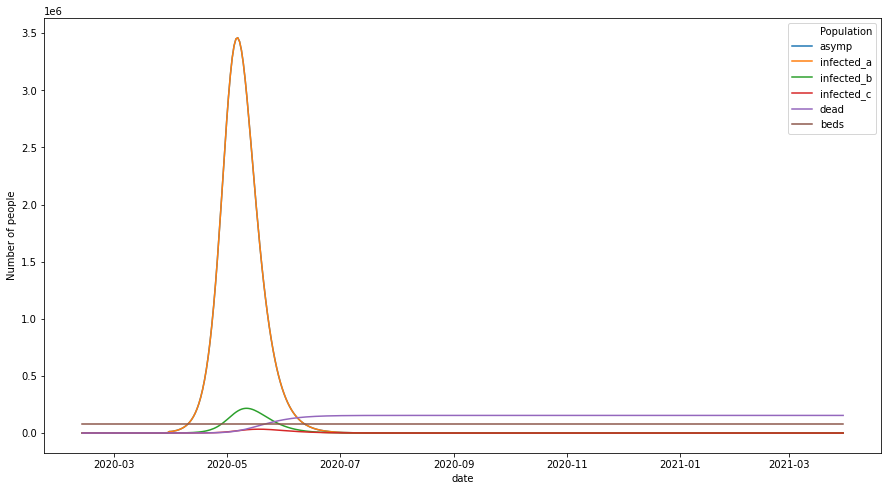

In [9]:
# display outputs - line chart
df['week'] = pd.DatetimeIndex(df['date']).week
chart_cols = ["asymp", "infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",
plot_df(df, chart_cols)

In [10]:
# # calculate doubling time by week
# avg_doubling = df.loc[:, ('week', 'doubling_time')].groupby('week').mean()
# print('avg doubling time by week')
# print(avg_doubling)